# Predicting House Prices

**Sales prices prediction using an artificial neural network in Keras**

**Supervised Learning. Regression**

Source: Ames Housing dataset ([Kaggle website](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)).  

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")
import helper_ds

import keras

helper_ds.set_parent_execution_path()
helper_ds.info_system()
sns.set_palette("GnBu_d")
# helper_ds.reproducible(seed=0) # Setup reproducible results from run to run using Keras

%matplotlib inline
%load_ext autoreload
%autoreload 2

Path changed to /home/angel/DRIVE/0_repos/data-science-keras

HARDWARE:
CPU:	Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
RAM:	15 GB
-- No GPU  --

OS:	Linux-5.15.0-46-generic-x86_64-with-glibc2.35

ENV:	/home/angel/miniconda3/envs/ds-keras

PYTHON:	3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
tensorflow                    2.9.1
pandas                        1.4.3
numpy                        1.23.1

EXECUTION PATH: /home/angel/DRIVE/0_repos/data-science-keras
EXECUTION DATE: Sun Aug 14 15:06:29 2022


## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_path = "data/house_prices_data.csv"
target = ["SalePrice"]

df_original = pd.read_csv(data_path)

### Explore the data

In [3]:
helper_ds.info_data(df_original, target)

Samples: 	1460 
Features: 	80
Target: 	SalePrice


In [4]:
df_original.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


#### Missing values

['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

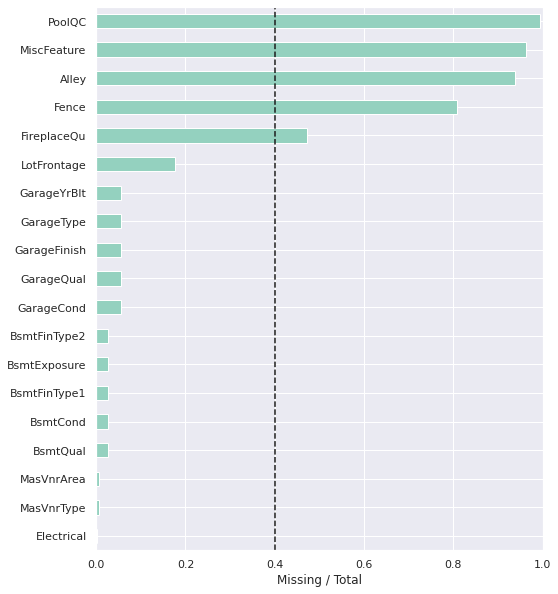

In [5]:
high_missing = helper_ds.missing(df_original, limit=0.4, plot=True)
high_missing

### Transform the data

#### Remove irrelevant features

In [6]:
df = df_original.copy()  # modified dataset

# remove non-significant and high-missing features
droplist = ["Id"] + high_missing

assert len(set(droplist).intersection(set(target))) == 0, "Targets cannot be dropped"

df.drop(droplist, axis="columns", inplace=True)

#### Classify variables

Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [7]:
numerical = list(df.select_dtypes(include=[np.number]))

df = helper_ds.sort_columns_by_type(df, target, numerical=numerical)

helper_ds.get_types(df)

36 numerical features: 	 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
38 categorical features: 	 ['BsmtQual', 'HouseStyle', 'BsmtCond', 'Electrical', 'ExterQual', 'GarageCond', 'LotShape', 'LandContour', 'SaleType', 'GarageQual', 'Functional', 'MasVnrType', 'KitchenQual', 'GarageFinish', 'Utilities', 'GarageType', 'Neighborhood', 'BsmtExposure', 'BsmtFinType1', 'ExterCond', 'Foundation', 'Condition1', 'Exterior2nd', 'BldgType', 'LandSlope', 'Street', 'RoofMatl', 'HeatingQC', 'Heating', 'RoofStyle', 'SaleCondition', 'Exterior1st', 'Central

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,RoofStyle,SaleCondition,Exterior1st,CentralAir,MSZoning,LotConfig,BsmtFinType2,PavedDrive,Condition2,SalePrice
Type,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,...,category,category,category,category,category,category,category,category,category,float32


#### Remove low frequency values from categorical features

In [8]:
df, dict_categories = helper_ds.remove_categories(df, target, ratio=0.01)

Removing 3 categories from feature HouseStyle
Removing 1 categories from feature BsmtCond
Removing 2 categories from feature Electrical
Removing 1 categories from feature ExterQual
Removing 3 categories from feature GarageCond
Removing 1 categories from feature LotShape
Removing 6 categories from feature SaleType
Removing 3 categories from feature GarageQual
Removing 3 categories from feature Functional
Removing 1 categories from feature Utilities
Removing 2 categories from feature GarageType
Removing 3 categories from feature Neighborhood
Removing 2 categories from feature ExterCond
Removing 2 categories from feature Foundation
Removing 4 categories from feature Condition1
Removing 6 categories from feature Exterior2nd
Removing 1 categories from feature LandSlope
Removing 1 categories from feature Street
Removing 7 categories from feature RoofMatl
Removing 1 categories from feature HeatingQC
Removing 4 categories from feature Heating
Removing 4 categories from feature RoofStyle
Removi

#### Fill missing values
Numerical -> median, categorical -> mode

In [9]:
df = helper_ds.fill_simple(df, target)

### Visualize the data

#### Target vs some significant features

(34900.0, 600000.0)

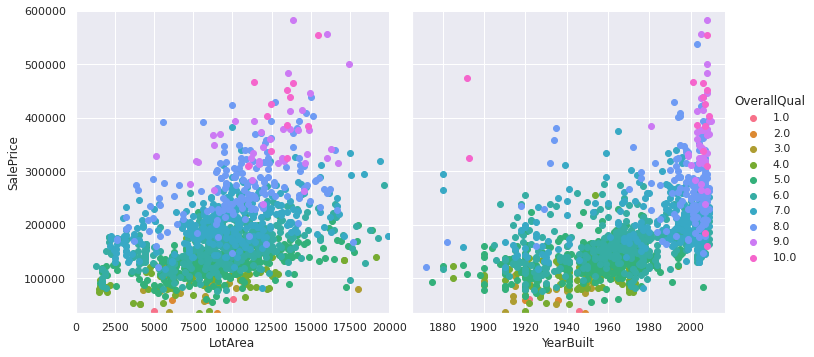

In [10]:
g = sns.PairGrid(df, y_vars=["SalePrice"], x_vars=["LotArea", "YearBuilt"], height=5, hue="OverallQual")
g.map(plt.scatter).add_legend()
g.axes[0, 0].set_xlim(0, 20000)
plt.ylim(df["SalePrice"].min(), 600000)

Lower sale prices are usually found in very low overall quality houses, with less dependency on its size and the year of construction. These three features alone are insufficient to make a good price prediction.

#### Categorical features

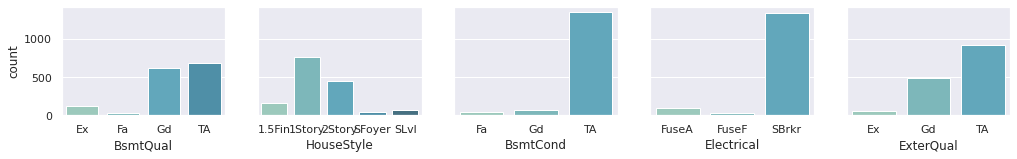

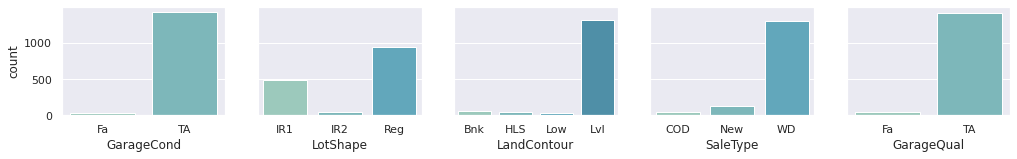

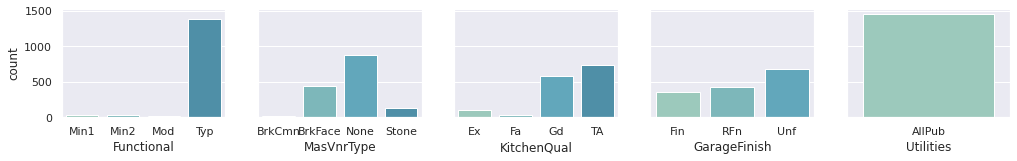

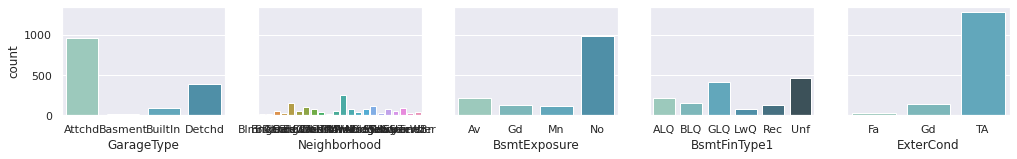

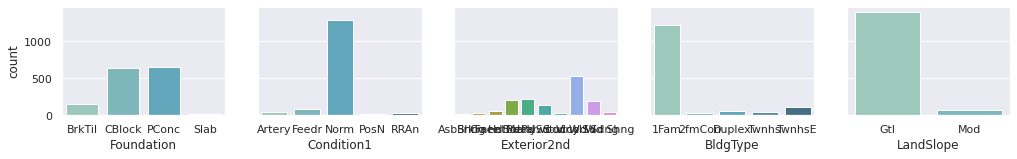

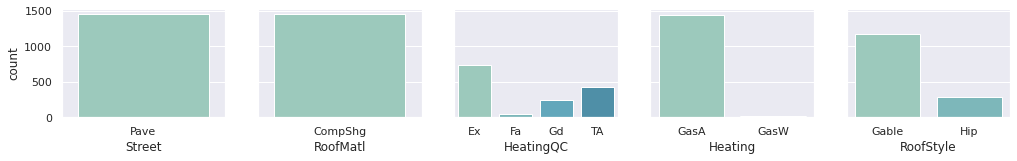

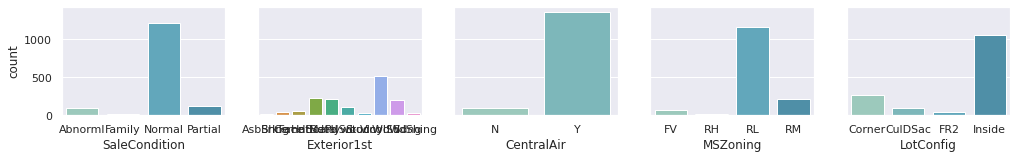

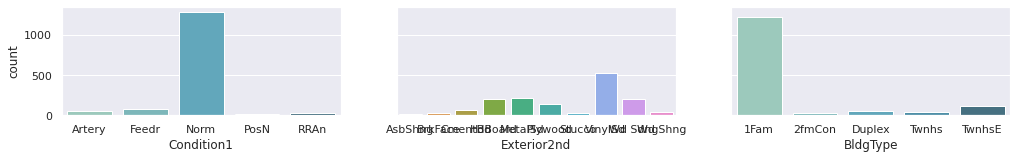

In [11]:
helper_ds.show_categorical(df, sharey=True)

#### Target vs Categorical features

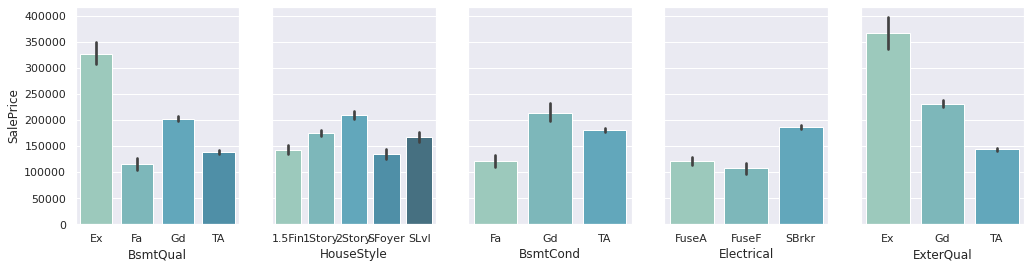

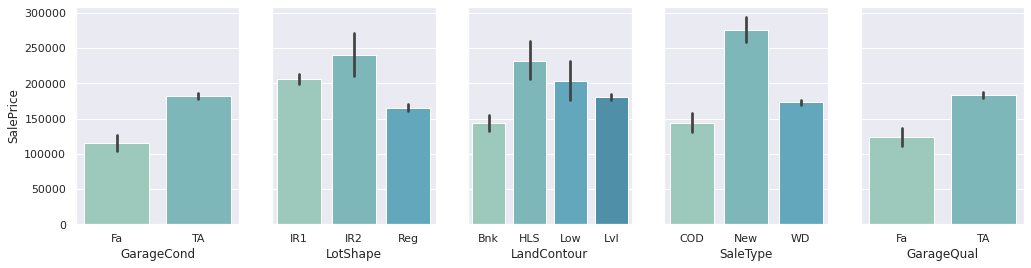

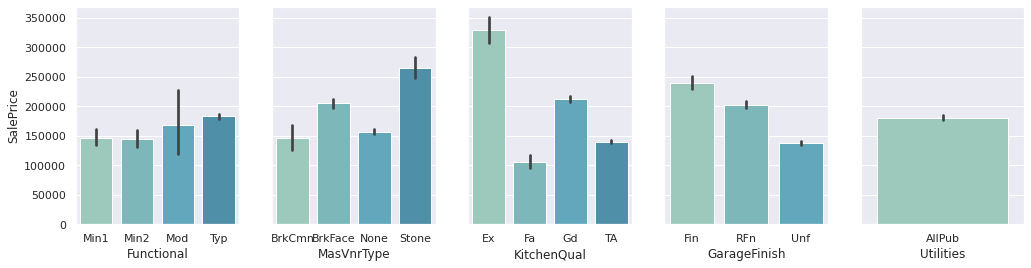

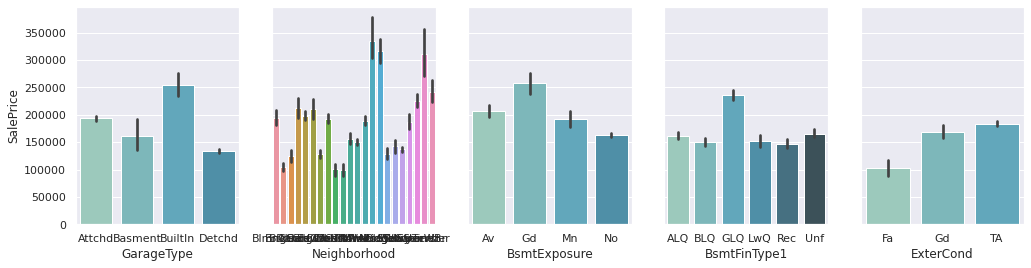

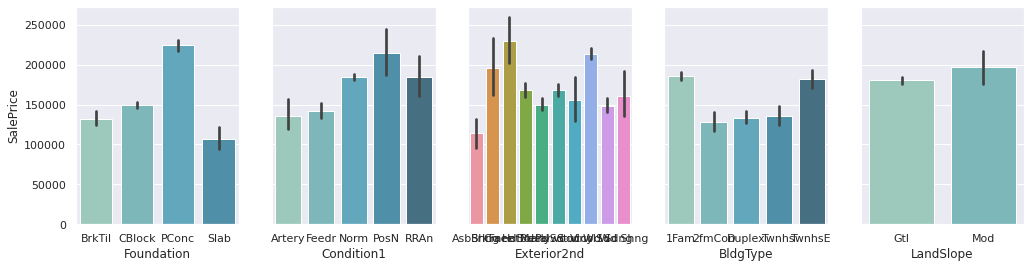

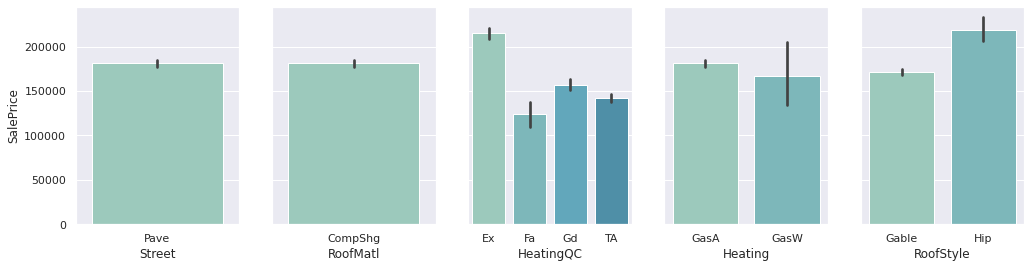

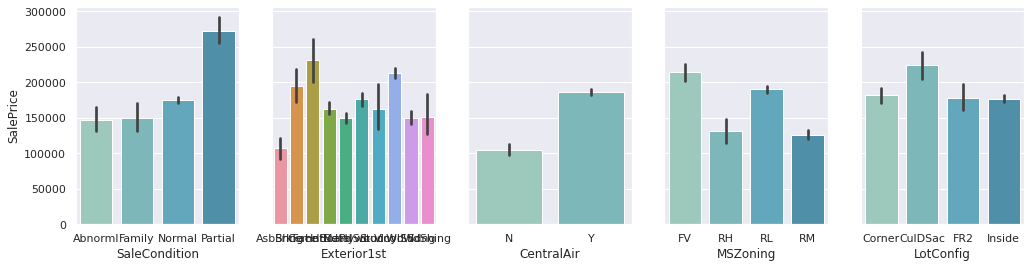

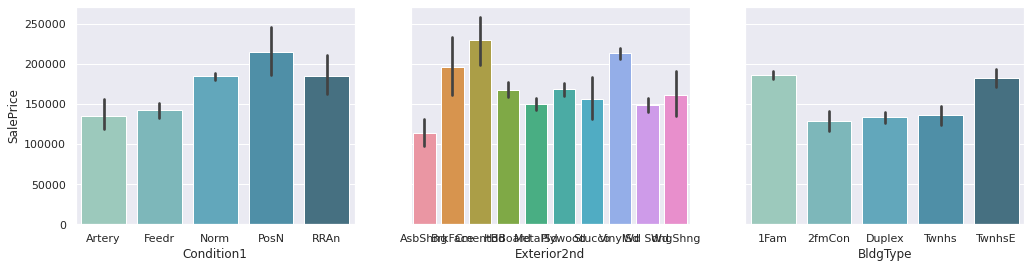

In [12]:
helper_ds.show_target_vs_categorical(df, target)

#### Numerical features

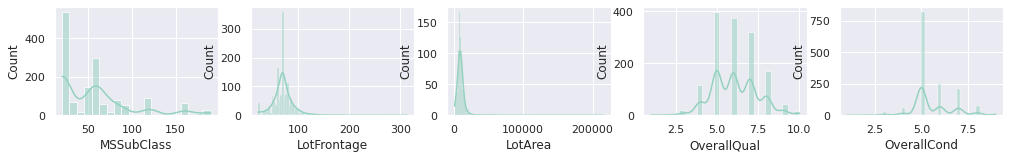

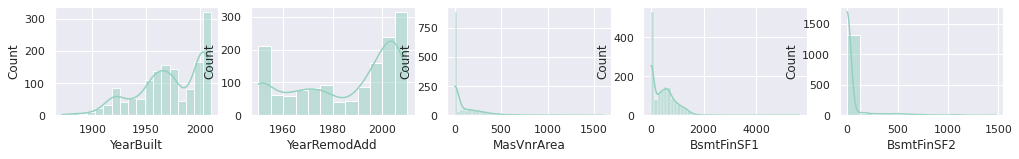

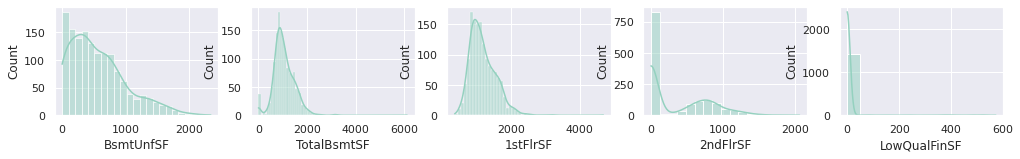

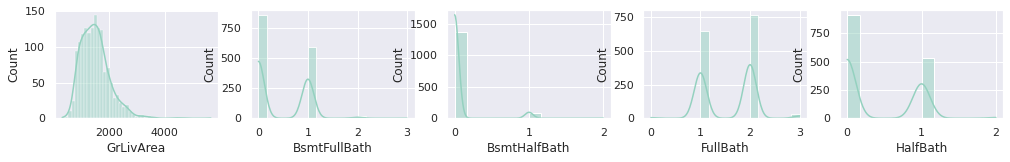

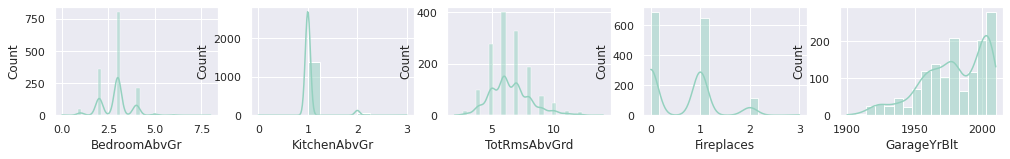

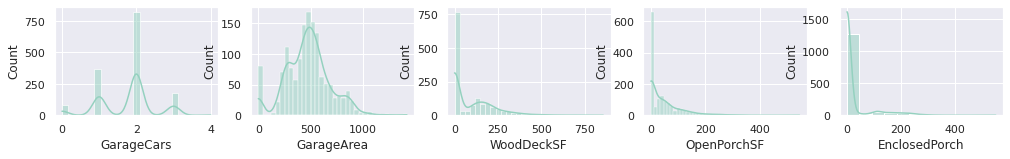

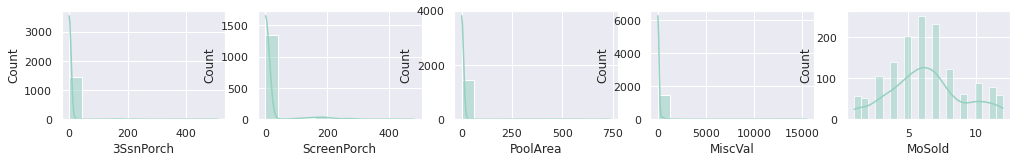

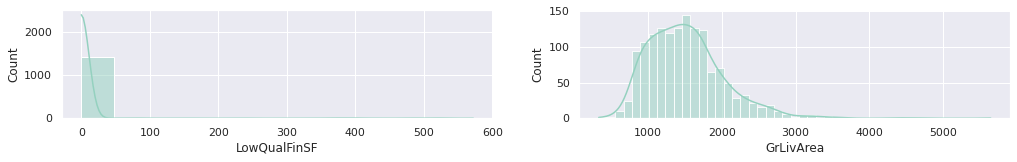

In [13]:
helper_ds.show_numerical(df, kde=True)

#### Target vs Numerical features

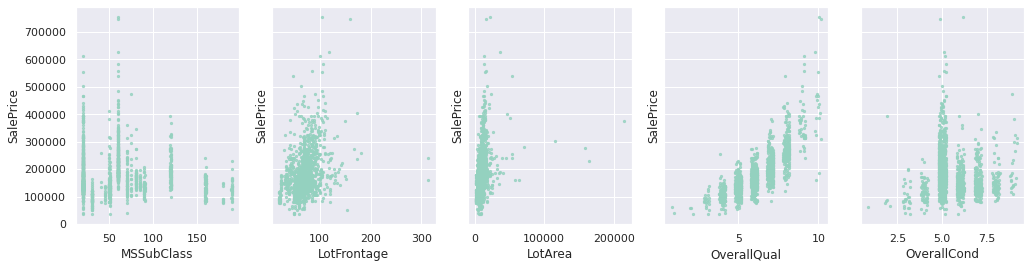

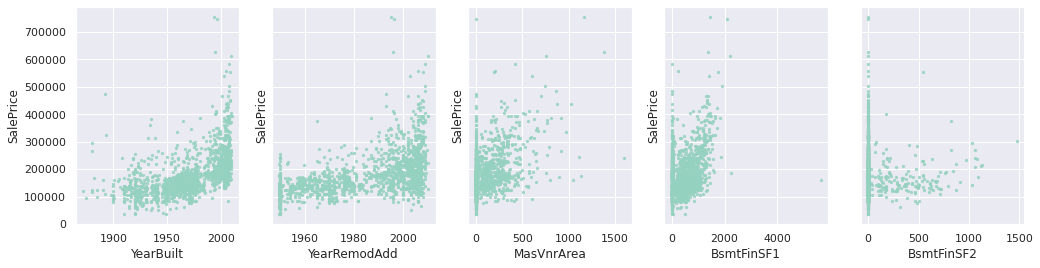

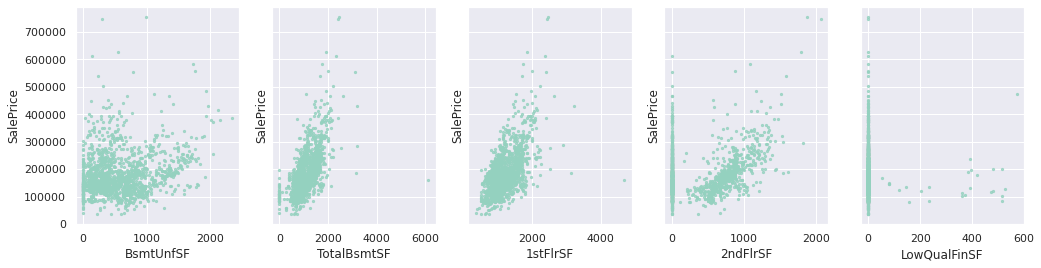

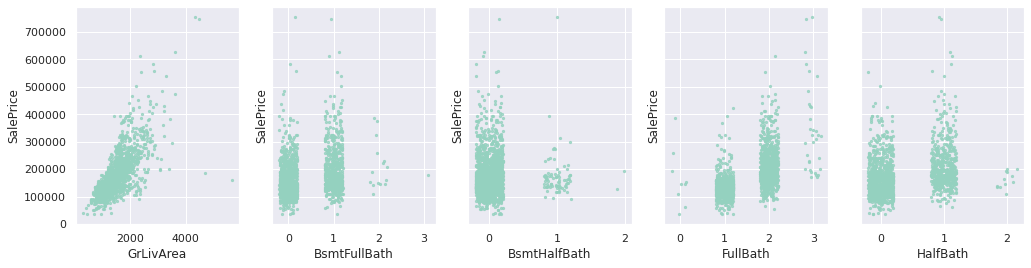

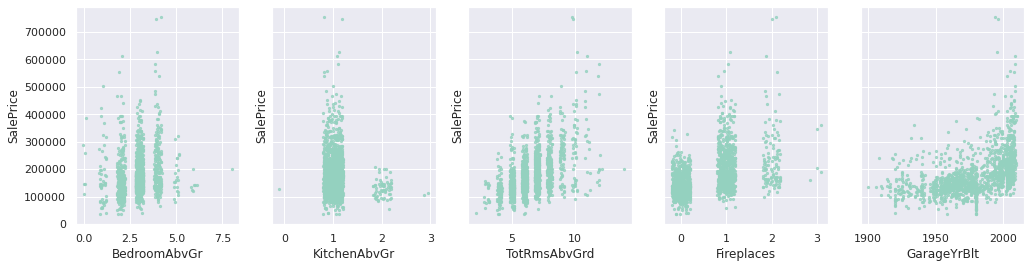

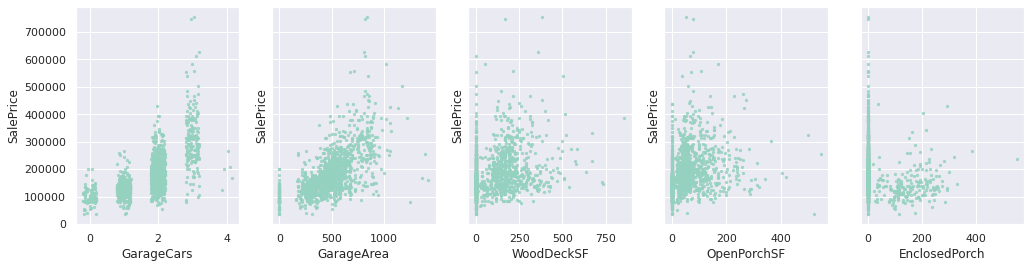

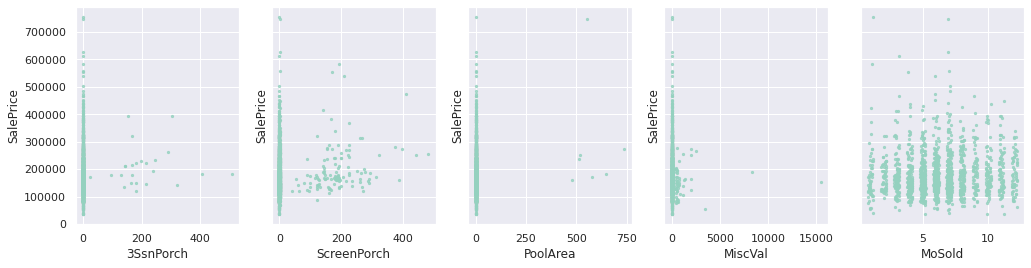

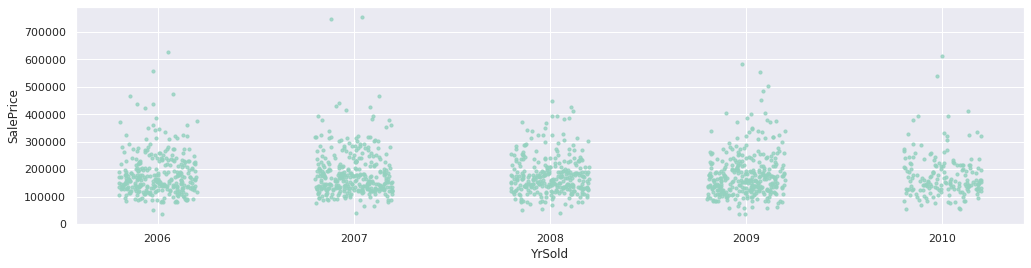

In [14]:
helper_ds.show_target_vs_numerical(df, target, point_size=20, jitter=0.2, fit_reg=False)

#### Correlation between numerical features and target

[]

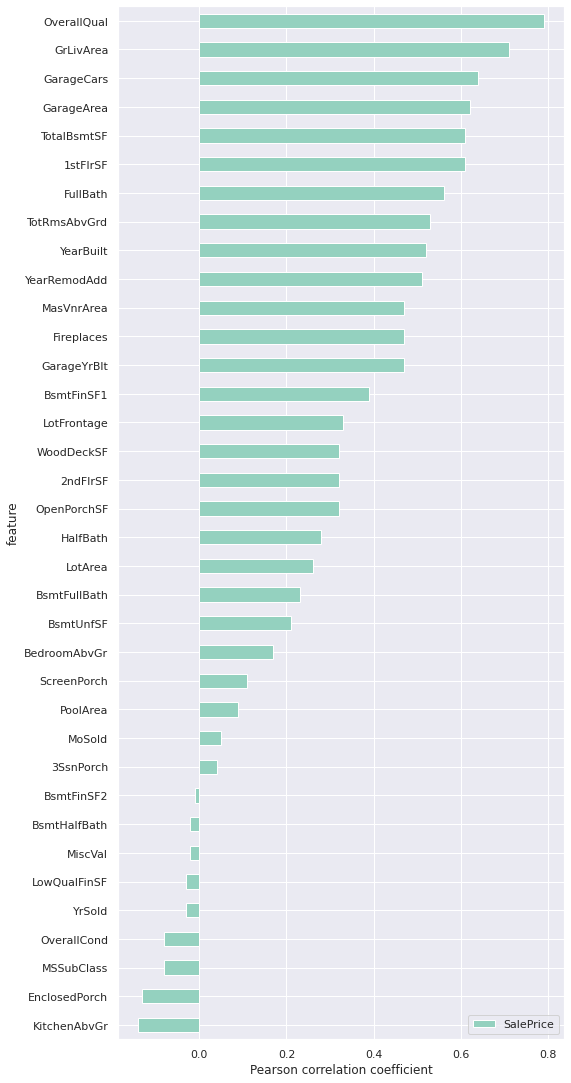

In [15]:
helper_ds.correlation(df, target)

## 2. Neural Network model

### Select the features

In [16]:
droplist = []  # features to drop

# For the model 'data' instead of 'df'
data = df.copy()
data.drop(droplist, axis="columns", inplace=True)
data.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,RoofStyle,SaleCondition,Exterior1st,CentralAir,MSZoning,LotConfig,BsmtFinType2,PavedDrive,Condition2,SalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,Gable,Normal,VinylSd,Y,RL,Inside,Unf,Y,Norm,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,Gable,Normal,MetalSd,Y,RL,FR2,Unf,Y,Norm,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,Gable,Normal,VinylSd,Y,RL,Inside,Unf,Y,Norm,223500.0


### Scale numerical variables
Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [17]:
data, scale_param = helper_ds.scale(data)

### Create dummy features
Replace categorical features (no target) with dummy features

In [18]:
data, dict_dummies = helper_ds.replace_by_dummies(data, target)

model_features = [f for f in data if f not in target]  # sorted neural network inputs

data.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PavedDrive_P,PavedDrive_Y,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn
0,0.073350,-0.220800,-0.207071,0.651256,-0.517023,1.050633,0.878369,0.513928,0.575228,-0.288554,...,0,1,0,0,1,0,0,0,0,0
1,-0.872264,0.460162,-0.091855,-0.071812,2.178881,0.156680,-0.429428,-0.570555,1.171591,-0.288554,...,0,1,0,0,1,0,0,0,0,0
2,0.073350,-0.084607,0.073455,0.651256,-0.517023,0.984414,0.829932,0.325803,0.092875,-0.288554,...,0,1,0,0,1,0,0,0,0,0


### Split the data into training, validation, and test sets
Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

In [19]:
test_size = 0.2
val_size = 0.1
random_state = 9

x_train, y_train, x_val, y_val, x_test, y_test = helper_ds.data_split_for_ml_with_val(
    data, target, test_size=test_size, val_size=val_size, random_state=random_state
)

train size 	 X:(1051, 270) 	 Y:(1051, 1)
validation size	 X:(117, 270) 	 Y:(117, 1)
test size  	 X:(292, 270) 	 Y:(292, 1) 


One-hot encode the output not needed for regression

### Build and Train the Neural Network

/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 135)               36585     
                                                                 
 dropout (Dropout)           (None, 135)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 136       
                                                                 
Total params: 36,721
Trainable params: 36,721
Non-trainable params: 0
_________________________________________________________________
Training ....
time: 	 5.7 s


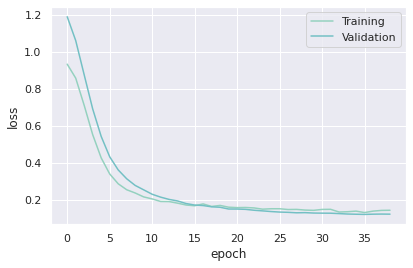


Training loss:  	0.1433
Validation loss: 	 0.1222

Model saved at models/house_prices.h5
4/4 [==============================] - 0s 1ms/step
Training   R2-score: 	0.868
Validation R2-score: 	0.900


In [20]:
model_path = os.path.join("models", "house_prices.h5")

weights = weights = keras.initializers.TruncatedNormal(stddev=0.0001)
opt = keras.optimizers.Adam(lr=0.00005)

model = None
model = helper_ds.build_nn_reg(
    x_train.shape[1],
    y_train.shape[1],
    hidden_layers=1,
    input_nodes=x_train.shape[1] // 2,
    dropout=0.2,
    kernel_initializer=weights,
    bias_initializer=weights,
    optimizer=opt,
    summary=True,
)

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=0)]

helper_ds.train_nn(
    model,
    x_train,
    y_train,
    validation_data=[x_val, y_val],
    path=model_path,
    epochs=500,
    batch_size=16,
    callbacks=callbacks,
)

from sklearn.metrics import r2_score

ypred_train = model.predict(x_train)
ypred_val = model.predict(x_val)
print("Training   R2-score: \t{:.3f}".format(r2_score(y_train, ypred_train)))
print("Validation R2-score: \t{:.3f}".format(r2_score(y_val, ypred_val)))

### Train with Cross Validation

In [21]:
# restore training set
x_train = np.vstack((x_train, x_val))
y_train = np.vstack((y_train, y_val))

In [22]:
from sklearn.model_selection import KFold


def cv_train_nn(x_train, y_train, n_splits):
    """Create and Train models for cross validation. Return best model"""

    skf = KFold(n_splits=n_splits, shuffle=True)

    score = []

    best_model = None
    best_loss = float("inf")

    print("Training {} models for Cross Validation ...".format(n_splits))

    for train, val in skf.split(x_train[:, 0], y_train[:, 0]):
        model = None
        model = helper_ds.build_nn_reg(
            x_train.shape[1],
            y_train.shape[1],
            hidden_layers=1,
            input_nodes=x_train.shape[1] // 2,
            dropout=0.2,
            kernel_initializer=weights,
            bias_initializer=weights,
            optimizer=opt,
            summary=False,
        )

        history = helper_ds.train_nn(
            model,
            x_train[train],
            y_train[train],
            show=False,
            validation_data=(x_train[val], y_train[val]),
            epochs=500,
            batch_size=16,
            callbacks=callbacks,
        )

        val_loss = history.history["val_loss"][-1]

        score.append(val_loss)

        if val_loss < best_loss:  # save best model (fold) for evaluation and predictions
            best_model = model
            best_loss = val_loss

    print("\nCross Validation loss: {:.3f}".format(np.mean(score)))
    return best_model


model = cv_train_nn(x_train, y_train, 10)

Training 10 models for Cross Validation ...

Cross Validation loss: 0.137


### Evaluate the model

In [23]:
y_pred_test = model.predict(x_test, verbose=0)
helper_ds.regression_scores(y_test, y_pred_test, return_dataframe=True, index="DNN")

,Loss,R2 Score
DNN,0.14,0.87


### Make predictions

SalePrice . Prediction error:
Mean: 	 0.40%
Stddev:  10.65%


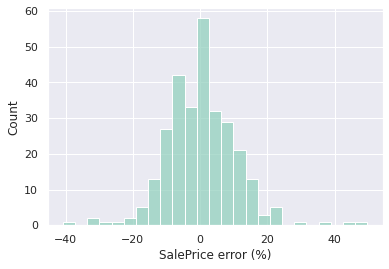

In [24]:
def predict_nn(model, x_test, target):
    """Return a dataframe with actual and predicted targets in original scale"""

    for t in target:
        pred = model.predict(x_test, verbose=0)
        restore_pred = pred * scale_param[t][1] + scale_param[t][0]
        restore_pred = restore_pred.round()

        restore_y = y_test * scale_param[t][1] + scale_param[t][0]
        restore_y = restore_y.round()

        pred_label = "Predicted_" + t
        error_label = t + " error (%)"

        pred_df = pd.DataFrame({t: np.squeeze(restore_y), pred_label: np.squeeze(restore_pred)})

        pred_df[error_label] = ((pred_df[pred_label] - pred_df[t]) * 100 / pred_df[t]).round(1)

        print(t, ". Prediction error:")
        print("Mean: \t {:.2f}%".format(pred_df[error_label].mean()))
        print("Stddev:  {:.2f}%".format(pred_df[error_label].std()))
        sns.histplot(pred_df[error_label])

    return pred_df


pred_df = predict_nn(model, x_test, target)

In [25]:
pred_df.head(10)

,SalePrice,Predicted_SalePrice,SalePrice error (%)
0,151400.0,209810.0,38.599998
1,241500.0,215067.0,-10.900000
2,82000.0,77388.0,-5.600000
3,162000.0,165356.0,2.100000
4,140000.0,145171.0,3.700000
5,227000.0,214119.0,-5.700000
6,228950.0,261567.0,14.200000
7,208300.0,189592.0,-9.000000
8,128500.0,123966.0,-3.500000
9,165000.0,166284.0,0.800000


The error of the predicted sale prices can be modeled by a normal distribution, almost zero centered, and with a standard deviation of < 12%. Thus, ~95% of the houses are predicted within a price error < 24% respect to the actual one. 

Note: there is data leakage when removing low-frequency categorical values and scaling numerical features


### Compare with classical ML

In [26]:
helper_ds.ml_regression(x_train, y_train, x_test, y_test)

Linear
KNeighbors
Random Forest
LGBM


,Time (s),Test loss,Test R2 score
Random Forest,2.2,0.12,0.89
Linear,0.1,0.14,0.87
LGBM,0.1,0.16,0.86
KNeighbors,0.0,0.29,0.74


####  Best tree-based model

In [27]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=9).fit(x_train, np.ravel(y_train))

y_pred = random_forest.predict(x_test)

helper_ds.regression_scores(y_test, y_pred, return_dataframe=True, index="Random Forest")

,Loss,R2 Score
Random Forest,0.12,0.89


#### Feature importance

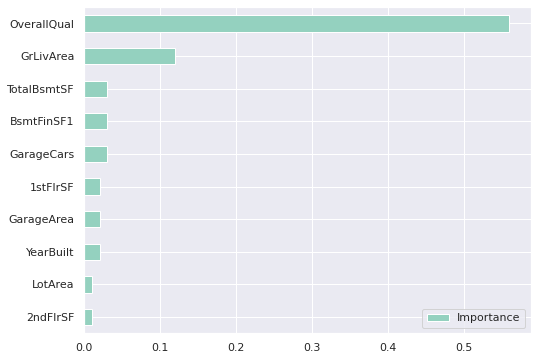

In [28]:
results = helper_ds.feature_importance(model_features, random_forest)